# Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import random
from scipy.stats import gaussian_kde
import seaborn as sns
import glob
import os

# A Breakdown of the GPU Memory when running `Qwen-2.5-7B-Instruct`

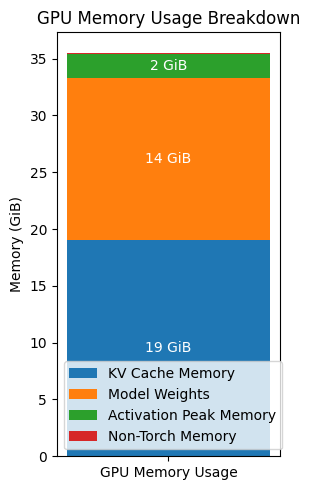

In [4]:
# Data
total_gpu_memory = 39.50
gpu_memory_utilization = 0.90
available_memory = total_gpu_memory * gpu_memory_utilization

model_weights = 14.2487
non_torch_memory = 0.09
activation_peak_memory = 2.13
kv_cache_memory = 19.07

# Labels and values
labels = ['GPU Memory Usage']
model_weights_values = [model_weights]
kv_cache_memory_values = [kv_cache_memory]
activation_peak_memory_values = [activation_peak_memory]
non_torch_memory_values = [non_torch_memory]

# Plotting
fig, ax = plt.subplots(figsize=(3, 5))

bar2 = ax.bar(labels, kv_cache_memory_values, label='KV Cache Memory')
bar1 = ax.bar(labels, model_weights_values, bottom=kv_cache_memory_values, label='Model Weights')
bar3 = ax.bar(labels, activation_peak_memory_values, bottom=[i+j for i,j in zip(model_weights_values, kv_cache_memory_values)], label='Activation Peak Memory')
bar4 = ax.bar(labels, non_torch_memory_values, bottom=[i+j+k for i,j,k in zip(model_weights_values, kv_cache_memory_values, activation_peak_memory_values)], label='Non-Torch Memory')

# Adding labels and title
ax.set_ylabel('Memory (GiB)')
ax.set_title('GPU Memory Usage Breakdown')
ax.legend()

# Function to add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f} GiB',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    xytext=(0, 0),  # No offset
                    textcoords="offset points",
                    ha='center', va='center', color='white', fontsize=10, fontweight='normal')

# Add labels to the bars
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Display the plot
plt.tight_layout()
plt.show()

# KV Cache Usage Timeline with Thoughts Annotated

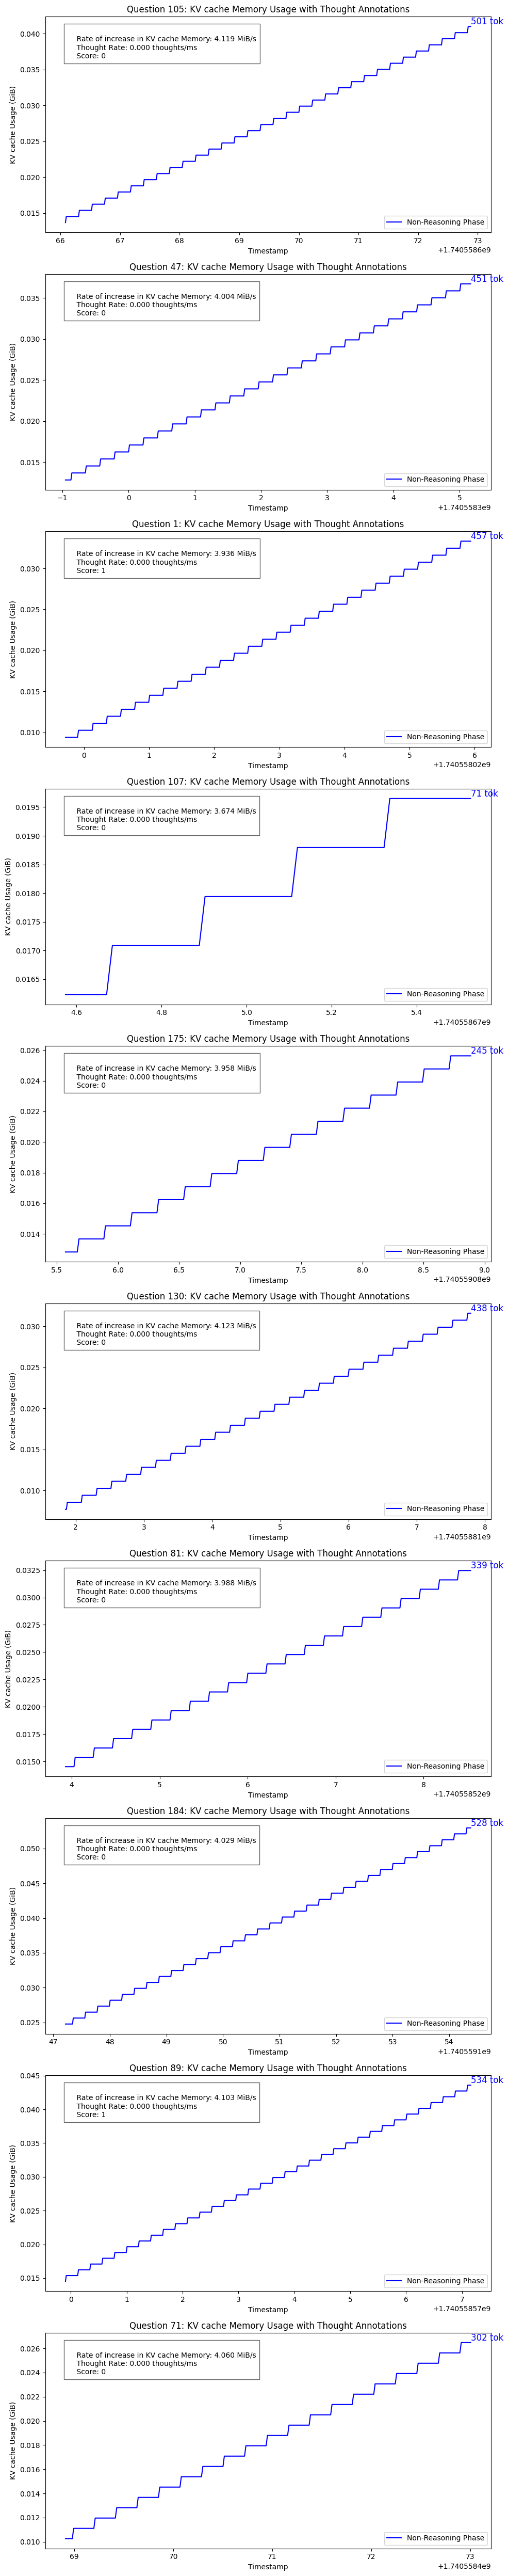

In [5]:
# Read token counts which contains the reasoning tokens counts for each question.
token_counts_path = '/Users/colinhong/Developer/vllm_experiments/qwen2.5_token_counts.csv'
df_counts = pd.read_csv(token_counts_path)

# Determine the number of questions based on the number of rows in token_counts.csv
num_questions = len(df_counts)

# Prepare filenames for each question CSV (the file has a header row with timestamp,gpu_cache_usage_sys)
question_files = [f'/Users/colinhong/Developer/vllm_experiments/qwen2.5_kvcache_usages/question_{i}.csv' for i in range(1, num_questions + 1)]

# Limit the number of questions to plot to avoid image size issues
max_questions_per_plot = 10
num_questions_to_plot = min(num_questions, max_questions_per_plot)  # Limit to 10 questions

# Select random question indices
selected_indices = random.sample(range(num_questions), num_questions_to_plot)
# selected_indices = [i for i in range(num_questions_to_plot)]

# Create one subplot per selected question.
fig, axes = plt.subplots(num_questions_to_plot, 1, figsize=(10, 5 * num_questions_to_plot), squeeze=False)

for plot_idx, question_idx in enumerate(selected_indices):
    ax = axes[plot_idx][0]
    file = question_files[question_idx]
    # Load the CSV for question and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[question_idx, 'Reasoning Tokens'])
    non_reasoning_count = len(timestamps) - reasoning_count

    # Compute the overall duration
    total_time = float(timestamps[-1]) - float(timestamps[0])
    gpu_rate = (usage[-1] - usage[0]) / total_time * 1024 if total_time > 0 else 0

    # Convert thought positions string to a list and compute thought rate.
    thought_positions_str = df_counts.loc[question_idx, 'Thought Positions']
    thought_positions = ast.literal_eval(thought_positions_str)
    thought_rate = len(thought_positions) / total_time * 1000 if total_time > 0 else 0

    gpu_info_labels = f"""
    Rate of increase in KV cache Memory: {gpu_rate:.3f} MiB/s
    Thought Rate: {thought_rate:.3f} thoughts/ms
    Score: {df_counts.loc[question_idx, 'Score']}"""

    ax.text(0.05, 0.95, gpu_info_labels,
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.6, pad=5))

    # Plot reasoning phase (first reasoning_count rows) in red.
    if reasoning_count > 0:
        ax.plot(timestamps[:reasoning_count], usage[:reasoning_count],
                color='red', label='Reasoning Phase')
        ax.text(timestamps[reasoning_count - 1], usage[reasoning_count - 1],
                f'{reasoning_count} tok', color='red', fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')

    # Plot non-reasoning phase (remaining rows) in blue.
    if reasoning_count < len(timestamps):
        ax.plot(timestamps[reasoning_count:], usage[reasoning_count:],
                color='blue', label='Non-Reasoning Phase')
        ax.text(timestamps[-1], usage[-1],
                f'{non_reasoning_count} tok', color='blue', fontsize=12,
                verticalalignment='bottom', horizontalalignment='left')

    # Mark and annotate each thought position from token_counts.csv
    for j, pos in enumerate(thought_positions):
        if pos < len(timestamps):
            ts = timestamps[pos]
            usage_val = usage[pos]
            ax.plot(ts, usage_val, 'ko', markersize=6)
            ax.text(ts, usage_val, f' Thought {j+1}', color='black', fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('KV cache Usage (GiB)')
    ax.set_title(f'Question {question_idx+1}: KV cache Memory Usage with Thought Annotations')
    ax.legend()

plt.tight_layout()
plt.show()

# Correlation between Completion Tokens and Score

<Figure size 1000x600 with 0 Axes>

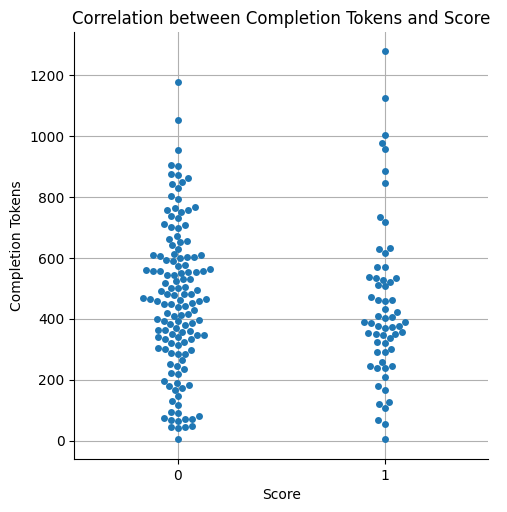

In [9]:
plt.figure(figsize=(10, 6))
sns.catplot(data=df_counts, x='Score', y='Completion Tokens', kind="swarm")
plt.title('Correlation between Completion Tokens and Score')
plt.xlabel('Score')
plt.ylabel('Completion Tokens')
plt.grid(True)
plt.show()

# Comparing KV Cache Usage between `Qwen2.5-7B-Instruct` and `DeepSeek-R1-Distill-Qwen-14B`

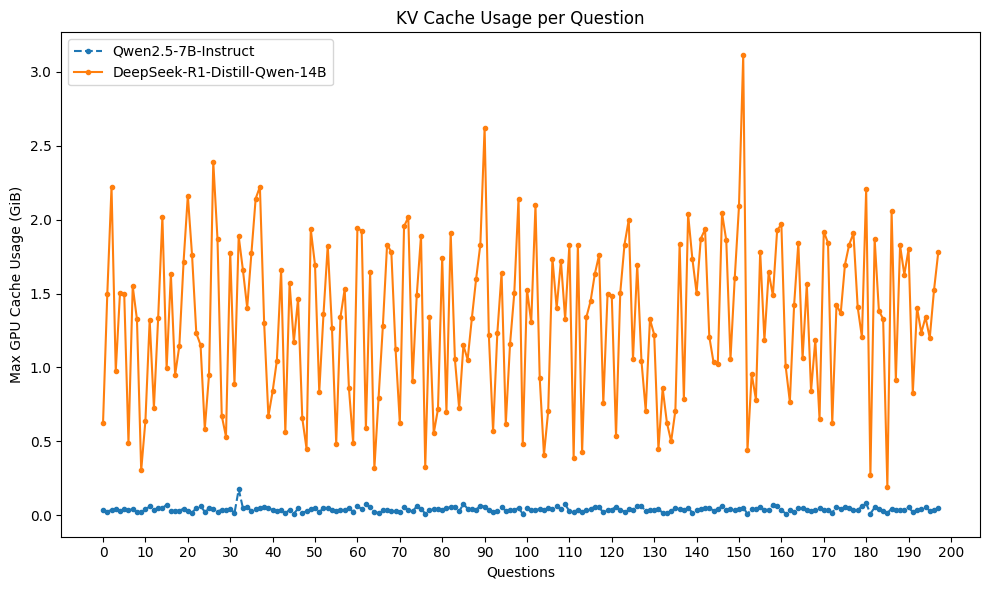

In [26]:
# Gather file lists from the two directories
qwen_files = glob.glob("qwen2.5_kvcache_usages/question_*.csv")
r1_files = glob.glob("r1_distill_kvcache_usages/question_*.csv")

# Dictionaries to store the maximum gpu_cache_usage_perc per question
qwen_usage = {}
r1_usage = {}

# Process qwen2.5 files
for file in qwen_files:
    df = pd.read_csv(file)
    question = os.path.basename(file).replace(".csv", "")
    qwen_usage[question] = df["gpu_cache_usage_perc"].max() * kv_cache_memory

r1_distill_kv_cache_memory = 6.38

# Process r1_distill files
for file in r1_files:
    df = pd.read_csv(file)
    question = os.path.basename(file).replace(".csv", "")
    r1_usage[question] = df["gpu_cache_usage_perc"].max() * r1_distill_kv_cache_memory

# Combine question names and sort them
questions = sorted(set(qwen_usage.keys()) | set(r1_usage.keys()))
qwen_vals = [qwen_usage.get(q, None) for q in questions]
r1_vals = [r1_usage.get(q, None) for q in questions]

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(questions, qwen_vals, marker='.', label='Qwen2.5-7B-Instruct', linestyle='--')
plt.plot(questions, r1_vals, marker='.', label='DeepSeek-R1-Distill-Qwen-14B', linestyle='-')
plt.xlabel("Questions")
plt.ylabel("Max GPU Cache Usage (GiB)")
plt.title("KV Cache Usage per Question")
plt.xticks([i for i in range(0, len(questions) + 10, 10)], [i for i in range(0, len(questions) + 10, 10)])
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Calculate the accuracy
accuracy = df_counts['Score'].mean() * 100

print(f'Accuracy of Qwen-2.5-7B-Instruct: {accuracy:.2f}')
print('Original Qwen-2.5-7B-Instruct model achieves 33.84% on GPQA Diamond')

Accuracy of Qwen-2.5-7B-Instruct: 31.31
Original Qwen-2.5-7B-Instruct model achieves 33.84% on GPQA Diamond
